In [1]:
import torch
import torch.nn.functional as F
import torchmetrics

import lightning as L

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from tests import test_category_embedder, test_house_price_regressor, print_dataset_info

B1. Data
---

a. Load the dataset using pandas

b. Create train, test and validation splits

c. Encode categorical features

d. Scale continuous features

e. Implement a PyTorch dataset

f. Create PyTorch dataloaders

### B1(a) Load the data using pandas

In [2]:
# data = ... TODO
data = pd.read_csv("hdb_price_prediction.csv")

# define the continuous and categorical columns
continuous_cols = [
    "dist_to_nearest_stn",
    "dist_to_dhoby",
    "degree_centrality",
    "eigenvector_centrality",
    "remaining_lease_years",
    "floor_area_sqm",
]

categorical_cols = ["month", "town", "flat_model_type", "storey_range"]

### B1(b) Temporal split with validation

Create a temporal split:

1.	Train/Val pool: all rows with year <= 2020.

2.	From this pool, randomly sample 10% of the dataset to create a validation set.

3.	Test set: all rows with year == 2021.

4.	Print shapes (n_rows, n_cols) for train_data, val_data, test_data.

In [3]:
# train_data, val_data, test_data = ... TODO

# Temporal split
train_val_data = data[data["year"] <= 2020]
test_data = data[data["year"] == 2021]

# Randomly sample 10% from train_val as validation
val_data = train_val_data.sample(frac=0.1, random_state=42)
train_data = train_val_data.drop(val_data.index)


In [4]:
# DO NOT MODIFY
train_data.shape, val_data.shape, test_data.shape

((78633, 14), (8737, 14), (29057, 14))

### B1(c) Encode categorical features w/o leakage

1.	Create an `sklearn.preprocessing.OrdinalEncoder` with handle_unknown="use_encoded_value", unknown_value=-1.

2.	Fit on train_data[categorical_cols] only.

3.	Transform val_data and test_data using the fitted encoder.

4. Compute and print the cardinality (number of distinct codes) for each categorical column on train_data after encoding. (These will be used to define embedding tables later.)

### B1(d) Scale continuous features w/o leakage

1.	Create a `StandardScaler`.

2.	Fit on train_data[continuous_cols] only.

3.	Transform val_data and test_data.

4.	Report the mean and std of each continuous feature on the transformed train split (they should be ~0 and ~1).

Do not scale resale_price.

In [5]:
# TODO

from sklearn.preprocessing import OrdinalEncoder, StandardScaler


# Create an OrdinalEncoder to convert categories into integer labels
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Fit on training data categorical columns
encoder.fit(train_data[categorical_cols])

# Transform the categorical features
train_data[categorical_cols] = encoder.transform(train_data[categorical_cols])
val_data[categorical_cols] = encoder.transform(val_data[categorical_cols])
test_data[categorical_cols] = encoder.transform(test_data[categorical_cols])


# Compute and display the number of unique values (cardinality)
cardinalities = {col: int(train_data[col].nunique()) for col in categorical_cols}
print("Categorical column cardinalities:", cardinalities)

# Create a StandardScaler to standardise continuous feature
scaler = StandardScaler()

# Fit on training data continuous columns
scaler.fit(train_data[continuous_cols])

# Transform the continous coloumns
train_data[continuous_cols] = scaler.transform(train_data[continuous_cols])
val_data[continuous_cols] = scaler.transform(val_data[continuous_cols])
test_data[continuous_cols] = scaler.transform(test_data[continuous_cols])


Categorical column cardinalities: {'month': 12, 'town': 26, 'flat_model_type': 43, 'storey_range': 17}


C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_28940\2950951385.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[categorical_cols] = encoder.transform(test_data[categorical_cols])
C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_28940\2950951385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[continuous_cols] = scaler.transform(test_data[continuous_cols])


In [6]:
# DO NOT MODIFY
train_data.shape, val_data.shape, test_data.shape

((78633, 14), (8737, 14), (29057, 14))

### B1(e) Implement a PyTorch Dataset

Implement HDBPriceDataset(Dataset) with:
- `__init__(self, data, categorical_cols, continuous_cols, target_col="resale_price")`

- `__getitem__(idx)` returns a dict: {"x_cat": LongTensor, "x_cont": FloatTensor, "y": FloatTensor}

In [7]:
from torch.utils.data import DataLoader, Dataset

# class HDBPriceDataset(Dataset):
#     ...

class HDBPriceDataset(Dataset):
    def __init__(self, data, categorical_cols, continuous_cols, target_col="resale_price"):
        """
        data: preprocessed pandas DataFrame
        categorical_cols: list of categorical feature names
        continuous_cols: list of continuous feature names
        target_col: 'resale_price'
        """
        self.categorical_data = torch.tensor(data[categorical_cols].values, dtype=torch.long)
        self.continuous_data = torch.tensor(data[continuous_cols].values, dtype=torch.float32)
        self.targets = torch.tensor(data[target_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        """
        Returns a dictionary for each sample:
        {
            "x_cat": LongTensor of categorical features,
            "x_cont": FloatTensor of continuous features,
            "y": FloatTensor of target value
        }
        """
        return {
            "x_cat": self.categorical_data[idx],
            "x_cont": self.continuous_data[idx],
            "y": self.targets[idx],
        }


### B1(f) Create train, validation and test data loaders

Create train, validation and test datasets and data loaders. Use a batch size of 1024

In [8]:
batch_size = 1024

# train_dataset, val_dataset, test_dataset = ...

# train_dataloader, val_dataloader, test_dataloader = ...

# Create Dataset objects
train_dataset = HDBPriceDataset(train_data, categorical_cols, continuous_cols)
val_dataset = HDBPriceDataset(val_data, categorical_cols, continuous_cols)
test_dataset = HDBPriceDataset(test_data, categorical_cols, continuous_cols)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# DO NOT MODIFY
print_dataset_info(train_dataset, test_dataset, train_loader, test_loader)

Dataset info:
Train samples: 78,633
Test samples: 29,057
Total batches (train): 77
Total batches (test): 29

Sample batch shapes:
Categorical: torch.Size([1024, 4])
Continuous: torch.Size([1024, 6])
Target: torch.Size([1024])


B2. Model and training
---
a. Create a PyTorch Model

b. Write a LightningModule for fitting the model

c. Train the model

d. Predict using the trained model on the test set and calculate $R^2$

### B2(a) Create a PyTorch Model

In this part you will build a PyTorch model for tabular house-price regression that (i) embeds each categorical feature into a dense vector, (ii) concatenates all category embeddings with the standardized continuous features, and (iii) predicts resale_price via a small MLP.

You must implement two modules:
1.	CategoryEmbedder — one embedding table per categorical column plus optional dropout.

2.	HousePriceRegressor — uses CategoryEmbedder, concatenates with continuous features, then a 3-layer MLP.

You will then instantiate the model using provided cardinalities and embedding dimensions.

Use the same feature schema and encoded/scaled splits you produced in Part 1. Assume you already have train_loader, val_loader, test_loader, continuous_cols, oe (the fitted OrdinalEncoder), and batch_size.

A. Implement CategoryEmbedder (10 pts)

Create a module that receives:
- cardinalities: List[int] — number of distinct codes per categorical column (from oe.categories_).

- embed_dims: List[int] — embedding dimension for each categorical column (same length as cardinalities).

- emb_dropout: float — dropout applied after concatenation of all embeddings.

Requirements

1.	Construct a nn.ModuleList of nn.Embedding(num_embeddings=c, embedding_dim=d) for each (c, d) pair.

2.	In forward(x_cat), where x_cat has shape [B, C] (C = #categorical columns):

	- Look up each column i using its table: emb_i(x_cat[:, i]) → [B, d_i].

	- Concatenate along feature dimension → [B, sum(embed_dims)].

	- Apply Dropout(emb_dropout) and return.

In [10]:
import torch.nn as nn

class CategoryEmbedder(nn.Module):
    def __init__(self, cardinalities, embed_dims, emb_dropout=0.0):
        """Initialize the CategoryEmbedder.
        Args:
            cardinalities (list): List of integers representing the number of unique values for each categorical feature.
            embed_dims (list): List of integers representing the embedding dimensions for each categorical feature.
            emb_dropout (float): Dropout rate for the embeddings.
        """
        super().__init__()
        assert len(cardinalities) == len(embed_dims), "Lengths of cardinalities and embed_dims must match."

        # Create embedding layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=c + 1, embedding_dim=d) # +1 to handle 'unknown' category, which maps from -1 to 0
            for c, d in zip(cardinalities, embed_dims)
        ])

        # Dropout layer after concatenating all embeddings
        self.dropout = nn.Dropout(p=emb_dropout)

    def forward(self, x_cat):
        x_cat = torch.clamp(x_cat + 1, min=0)
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(embedded, dim=1)
        return self.dropout(x)


In [11]:
test_category_embedder(CategoryEmbedder)

Test 1: Basic functionality
Input shape: torch.Size([32, 3])
Output shape: torch.Size([32, 14])
Expected output dim: 14
✓ Basic functionality test passed

Test 2: Single categorical feature
✓ Single feature test passed

Test 3: Edge case with minimum values
✓ Minimum values test passed

All tests passed! 🎉


In [12]:
class HousePriceRegressor(nn.Module):
    def __init__(self, cardinalities, embed_dims, n_continuous, emb_dropout=0.0):
        """Initialize the HousePriceRegressor.

        Args:
            cardinalities (list): List of integers representing the number of unique values for each categorical feature.
            embed_dims (list): List of integers representing the embedding dimensions for each categorical feature.
            n_continuous (int): Number of continuous features.
            emb_dropout (float, optional): Dropout rate for the embeddings. Defaults to 0.0.
        """
        super().__init__()

        # Embedder for categorical features
        self.embedder = CategoryEmbedder(cardinalities, embed_dims, emb_dropout)

        # Total input dimension = all embeddings + continuous features
        input_dim = sum(embed_dims) + n_continuous

        # Define 3-layer MLP with ReLU and Dropout
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)  # regression output
        )

    def forward(self, x_cat, x_cont):
    #    ... TODO

        """
        Args:
            x_cat (Tensor): LongTensor of shape [batch_size, num_categorical_features].
            x_cont (Tensor): FloatTensor of shape [batch_size, num_continuous_features].
        Returns:
            Tensor: Predicted resale price, shape [batch_size, 1].
        """
        # Get categorical embeddings
        x_emb = self.embedder(x_cat)

        # Concatenate categorical embeddings + continuous features
        x = torch.cat([x_emb, x_cont], dim=1)

        # Pass through MLP
        out = self.mlp(x)

        # Flatten to shape 
        return out.squeeze(1)

In [13]:
# DO NOT MODIFY
test_house_price_regressor(HousePriceRegressor)

Testing HousePriceRegressor...
Categorical input shape: torch.Size([32, 4])
Continuous input shape: torch.Size([32, 6])
Output shape: torch.Size([32])
Output type: torch.float32
Sample predictions: [-0.14766371250152588, -0.21835584938526154, -0.03718949854373932, -0.10371476411819458, -0.062224626541137695]
✓ Basic functionality test passed
✓ Batch size 1 test passed
✓ Batch size 16 test passed
✓ Batch size 64 test passed
✓ Batch size 128 test passed

Model info:
Total parameters: 43,621
Trainable parameters: 43,621

All HousePriceRegressor tests passed! 🎉


In [14]:
oe = encoder

# DO NOT MODIFY
cardinalities = [len(categories) for categories in oe.categories_]
embedding_dims = [min(50, (c + 1) // 2) for c in cardinalities]
n_continuous = len(continuous_cols)

# Create model with proper cardinalities
model = HousePriceRegressor(
    cardinalities=cardinalities,
    embed_dims=embedding_dims,
    n_continuous=n_continuous,
    emb_dropout=0.1,
)

### B2(b) PyTorch LightningModule

Wrap your HousePriceRegressor into a PyTorch LightningModule so that training, validation, and testing are managed automatically.

What to do

1.	Initialize the module
    - Store hyperparameters (embedding sizes, number of continuous features, learning rate, etc.).

    - Create an instance of your HousePriceRegressor.

    - Choose a suitable regression loss function (e.g., MSE).

    - Set up at least one evaluation metric (e.g., MAE, RMSE).

2.	Forward method
    - Define a forward pass that takes categorical + continuous features and returns predictions.

3.	Training, Validation, and Test steps
    - In each step:
        - Extract features and target from the batch.

        - Run the model forward.

        - Compute the loss.

        - Log the loss and chosen metrics so they can be monitored.

4.	Prediction step
    - Implement a method to return predictions on new data without computing loss.

5.	Optimiser
    - Use a suitable optimiser (e.g., Adam) with a reasonable learning rate.

    - (Optional: add a scheduler if you wish to experiment.)

In [15]:
from torchmetrics import MeanAbsoluteError, MeanSquaredError

class HDBPriceLightningModule(L.LightningModule):
    # ... TODO

    def __init__(self, cardinalities, embedding_dims, n_continuous, emb_dropout=0.1, lr=1e-3):
        super().__init__()

        # Save hyperparameters for checkpointing/logging
        self.save_hyperparameters()

        # Create the model
        self.model = HousePriceRegressor(
            cardinalities=cardinalities,
            embed_dims=embedding_dims,
            n_continuous=n_continuous,
            emb_dropout=emb_dropout
        )

        # Define the loss function (MSE for regression)
        self.criterion = nn.MSELoss()

        # Define the evaluation metrics
        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()

        self.train_rmse = MeanSquaredError(squared=False)
        self.val_rmse = MeanSquaredError(squared=False)
        self.test_rmse = MeanSquaredError(squared=False)


    # Forward Pass
    def forward(self, x_cat, x_cont):
        return self.model(x_cat, x_cont)

    # Training Step
    def training_step(self, batch, batch_idx):
        x_cat, x_cont, y = batch["x_cat"], batch["x_cont"], batch["y"]
        preds = self(x_cat, x_cont)
        loss = self.criterion(preds, y)

        # Update metrics
        self.train_mae.update(preds, y)
        self.train_rmse.update(preds, y)

        # Log metrics
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_mae", self.train_mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_rmse", self.train_rmse, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    # Validation Step
    def validation_step(self, batch, batch_idx):
        x_cat, x_cont, y = batch["x_cat"], batch["x_cont"], batch["y"]
        preds = self(x_cat, x_cont)
        loss = self.criterion(preds, y)

        self.val_mae.update(preds, y)
        self.val_rmse.update(preds, y)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_mae", self.val_mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_rmse", self.val_rmse, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # Test Step
    def test_step(self, batch, batch_idx):
        x_cat, x_cont, y = batch["x_cat"], batch["x_cont"], batch["y"]
        preds = self(x_cat, x_cont)
        loss = self.criterion(preds, y)

        self.test_mae.update(preds, y)
        self.test_rmse.update(preds, y)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_mae", self.test_mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_rmse", self.test_rmse, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # Prediction Step
    def predict_step(self, batch, batch_idx):
        x_cat, x_cont = batch["x_cat"], batch["x_cont"]
        return self(x_cat, x_cont)

    # Optimizer
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

In [16]:
# DO NOT MODIFY
lightning_model = HDBPriceLightningModule(
    cardinalities=cardinalities,
    embedding_dims=embedding_dims,
    n_continuous=n_continuous,
    emb_dropout=0.1,
)

### B2(c) Train the model

What to do
1.	Checkpoints
    - Add a checkpoint callback that monitors validation loss and keeps the best models (e.g., top-k) plus the last checkpoint for resuming.

2.	Early stopping
    - Add early stopping on the same validation metric with a reasonable patience and a small min_delta (use a tiny positive value to require real improvement).

3.	Learning-rate tracking
    - Log the learning rate each epoch/step with a LR monitor so it’s visible in your logger.

4.	Experiment logging
    - Create a logger (e.g., TensorBoard) with a clear experiment name and save directory.

5.	Trainer configuration
    - Set a sensible number of epochs, devices/accelerator (CPU/GPU), and enable gradient clipping.

    - Turn on progress bar and model summary for visibility.

    - Choose an appropriate logging frequency for your dataset size.

6.	Fit & Test
- Call trainer.fit(model, train_loader, val_loader).

- Optionally run trainer.test(model, test_loader) after training and print metrics.

7. Download the plots for validation loss, your validation metric and display it.

In [17]:
max_epochs = 50
# TODO:

from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",              # monitor validation loss
    mode="min",                      # minimize loss
    save_top_k=1,                    # save the best model
    save_last=True,                  # save the last epoch
    filename="best-checkpoint-{epoch:02d}-{val_loss:.4f}",
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,                      # stop after 5 epochs without improvement
    min_delta=1e-4,                  # require small real improvement
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Logger
logger = TensorBoardLogger(
    save_dir="lightning_logs",
    name="hdb_price_regression"
)

# Trainer configuration
trainer = L.Trainer(
    max_epochs=max_epochs,
    accelerator="auto",              # automatically use GPU if available
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    enable_progress_bar=True,
    gradient_clip_val=1.0,   
    log_every_n_steps=10
)

# Fit the model
trainer.fit(lightning_model, train_loader, val_loader)

# Evaluate on test data 
test_results = trainer.test(lightning_model, test_loader)

# Print metrics
print("\nTest Results:")
print(test_results)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | model      | HousePriceRegressor | 49.2 K | train
1 | criterion  | MSELoss             | 0      | train
2 | train_mae  | MeanAbsoluteError   | 0      | train
3 | val_mae    | MeanAbsoluteError   | 0      | train
4 | test_mae   | MeanAbsoluteError   | 0      | train
5 | train_rmse | MeanSquaredError    | 0      | train
6 | val_rmse   | MeanSquaredError    | 0      | train
7 | test_rmse  | MeanSquaredError    | 0      | train
-----------------------------------------------------------
49.2 K    Trainable params
0         Non-trainable params
49.2 K    Total params
0.197     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001 Programming Assignment 1\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Jun Sheng\OneDrive\Desktop\SC4001 Programming Assignment 1\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 77/77 [00:02<00:00, 26.86it/s, v_num=13, val_loss=2.16e+11, val_mae=4.39e+5, val_rmse=4.65e+5, train_loss=2.2e+11, train_mae=4.43e+5, train_rmse=4.69e+5]

Metric val_loss improved. New best score: 215783817216.000
Epoch 0, global step 77: 'val_loss' reached 215783817216.00000 (best 215783817216.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=00-val_loss=215783817216.0000.ckpt' as top 1


Epoch 1: 100%|██████████| 77/77 [00:02<00:00, 26.44it/s, v_num=13, val_loss=2.15e+11, val_mae=4.37e+5, val_rmse=4.63e+5, train_loss=2.19e+11, train_mae=4.42e+5, train_rmse=4.68e+5]

Metric val_loss improved by 1168637952.000 >= min_delta = 0.0001. New best score: 214615179264.000
Epoch 1, global step 154: 'val_loss' reached 214615179264.00000 (best 214615179264.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=01-val_loss=214615179264.0000.ckpt' as top 1


Epoch 2: 100%|██████████| 77/77 [00:03<00:00, 25.54it/s, v_num=13, val_loss=2.11e+11, val_mae=4.33e+5, val_rmse=4.59e+5, train_loss=2.17e+11, train_mae=4.4e+5, train_rmse=4.66e+5] 

Metric val_loss improved by 3616899072.000 >= min_delta = 0.0001. New best score: 210998280192.000
Epoch 2, global step 231: 'val_loss' reached 210998280192.00000 (best 210998280192.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=02-val_loss=210998280192.0000.ckpt' as top 1


Epoch 3: 100%|██████████| 77/77 [00:02<00:00, 26.54it/s, v_num=13, val_loss=2.03e+11, val_mae=4.24e+5, val_rmse=4.51e+5, train_loss=2.11e+11, train_mae=4.33e+5, train_rmse=4.6e+5]

Metric val_loss improved by 8047869952.000 >= min_delta = 0.0001. New best score: 202950410240.000
Epoch 3, global step 308: 'val_loss' reached 202950410240.00000 (best 202950410240.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=03-val_loss=202950410240.0000.ckpt' as top 1


Epoch 4: 100%|██████████| 77/77 [00:02<00:00, 26.34it/s, v_num=13, val_loss=1.88e+11, val_mae=4.07e+5, val_rmse=4.34e+5, train_loss=2e+11, train_mae=4.2e+5, train_rmse=4.47e+5]   

Metric val_loss improved by 14585282560.000 >= min_delta = 0.0001. New best score: 188365127680.000
Epoch 4, global step 385: 'val_loss' reached 188365127680.00000 (best 188365127680.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=04-val_loss=188365127680.0000.ckpt' as top 1


Epoch 5: 100%|██████████| 77/77 [00:02<00:00, 27.45it/s, v_num=13, val_loss=1.65e+11, val_mae=3.77e+5, val_rmse=4.07e+5, train_loss=1.81e+11, train_mae=3.97e+5, train_rmse=4.26e+5]

Metric val_loss improved by 23003414528.000 >= min_delta = 0.0001. New best score: 165361713152.000
Epoch 5, global step 462: 'val_loss' reached 165361713152.00000 (best 165361713152.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=05-val_loss=165361713152.0000.ckpt' as top 1


Epoch 6: 100%|██████████| 77/77 [00:02<00:00, 27.05it/s, v_num=13, val_loss=1.33e+11, val_mae=3.32e+5, val_rmse=3.65e+5, train_loss=1.54e+11, train_mae=3.61e+5, train_rmse=3.92e+5]

Metric val_loss improved by 32214917120.000 >= min_delta = 0.0001. New best score: 133146796032.000
Epoch 6, global step 539: 'val_loss' reached 133146796032.00000 (best 133146796032.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=06-val_loss=133146796032.0000.ckpt' as top 1


Epoch 7: 100%|██████████| 77/77 [00:02<00:00, 26.89it/s, v_num=13, val_loss=9.34e+10, val_mae=2.66e+5, val_rmse=3.06e+5, train_loss=1.17e+11, train_mae=3.05e+5, train_rmse=3.42e+5]

Metric val_loss improved by 39758233600.000 >= min_delta = 0.0001. New best score: 93388562432.000
Epoch 7, global step 616: 'val_loss' reached 93388562432.00000 (best 93388562432.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=07-val_loss=93388562432.0000.ckpt' as top 1


Epoch 8: 100%|██████████| 77/77 [00:03<00:00, 25.64it/s, v_num=13, val_loss=5.23e+10, val_mae=1.77e+5, val_rmse=2.29e+5, train_loss=7.55e+10, train_mae=2.27e+5, train_rmse=2.75e+5]

Metric val_loss improved by 41046122496.000 >= min_delta = 0.0001. New best score: 52342439936.000
Epoch 8, global step 693: 'val_loss' reached 52342439936.00000 (best 52342439936.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=08-val_loss=52342439936.0000.ckpt' as top 1


Epoch 9: 100%|██████████| 77/77 [00:03<00:00, 25.25it/s, v_num=13, val_loss=2.31e+10, val_mae=1.04e+5, val_rmse=1.52e+5, train_loss=3.86e+10, train_mae=1.41e+5, train_rmse=1.97e+5]

Metric val_loss improved by 29263206400.000 >= min_delta = 0.0001. New best score: 23079233536.000
Epoch 9, global step 770: 'val_loss' reached 23079233536.00000 (best 23079233536.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=09-val_loss=23079233536.0000.ckpt' as top 1


Epoch 10: 100%|██████████| 77/77 [00:03<00:00, 24.89it/s, v_num=13, val_loss=1.25e+10, val_mae=8.09e+4, val_rmse=1.12e+5, train_loss=1.93e+10, train_mae=1.01e+5, train_rmse=1.39e+5]

Metric val_loss improved by 10601436160.000 >= min_delta = 0.0001. New best score: 12477797376.000
Epoch 10, global step 847: 'val_loss' reached 12477797376.00000 (best 12477797376.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=10-val_loss=12477797376.0000.ckpt' as top 1


Epoch 11: 100%|██████████| 77/77 [00:02<00:00, 26.82it/s, v_num=13, val_loss=8.02e+9, val_mae=6.31e+4, val_rmse=8.95e+4, train_loss=1.21e+10, train_mae=7.99e+4, train_rmse=1.1e+5]  

Metric val_loss improved by 4461509632.000 >= min_delta = 0.0001. New best score: 8016287744.000
Epoch 11, global step 924: 'val_loss' reached 8016287744.00000 (best 8016287744.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=11-val_loss=8016287744.0000.ckpt' as top 1


Epoch 12: 100%|██████████| 77/77 [00:03<00:00, 24.97it/s, v_num=13, val_loss=5.72e+9, val_mae=5.26e+4, val_rmse=7.56e+4, train_loss=8.83e+9, train_mae=6.83e+4, train_rmse=9.4e+4] 

Metric val_loss improved by 2293453312.000 >= min_delta = 0.0001. New best score: 5722834432.000
Epoch 12, global step 1001: 'val_loss' reached 5722834432.00000 (best 5722834432.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=12-val_loss=5722834432.0000.ckpt' as top 1


Epoch 13: 100%|██████████| 77/77 [00:02<00:00, 26.07it/s, v_num=13, val_loss=4.54e+9, val_mae=4.82e+4, val_rmse=6.74e+4, train_loss=7.09e+9, train_mae=6.2e+4, train_rmse=8.42e+4]

Metric val_loss improved by 1179443712.000 >= min_delta = 0.0001. New best score: 4543390720.000
Epoch 13, global step 1078: 'val_loss' reached 4543390720.00000 (best 4543390720.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=13-val_loss=4543390720.0000.ckpt' as top 1


Epoch 14: 100%|██████████| 77/77 [00:02<00:00, 27.21it/s, v_num=13, val_loss=3.91e+9, val_mae=4.55e+4, val_rmse=62510.5, train_loss=6.15e+9, train_mae=5.85e+4, train_rmse=7.84e+4]

Metric val_loss improved by 635828224.000 >= min_delta = 0.0001. New best score: 3907562496.000
Epoch 14, global step 1155: 'val_loss' reached 3907562496.00000 (best 3907562496.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=14-val_loss=3907562496.0000.ckpt' as top 1


Epoch 15: 100%|██████████| 77/77 [00:02<00:00, 29.92it/s, v_num=13, val_loss=3.57e+9, val_mae=4.38e+4, val_rmse=5.97e+4, train_loss=5.72e+9, train_mae=5.68e+4, train_rmse=7.56e+4]

Metric val_loss improved by 340677376.000 >= min_delta = 0.0001. New best score: 3566885120.000
Epoch 15, global step 1232: 'val_loss' reached 3566885120.00000 (best 3566885120.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=15-val_loss=3566885120.0000.ckpt' as top 1


Epoch 16: 100%|██████████| 77/77 [00:02<00:00, 27.08it/s, v_num=13, val_loss=3.38e+9, val_mae=4.26e+4, val_rmse=58095.0, train_loss=5.42e+9, train_mae=5.55e+4, train_rmse=7.36e+4]

Metric val_loss improved by 191856384.000 >= min_delta = 0.0001. New best score: 3375028736.000
Epoch 16, global step 1309: 'val_loss' reached 3375028736.00000 (best 3375028736.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=16-val_loss=3375028736.0000.ckpt' as top 1


Epoch 17: 100%|██████████| 77/77 [00:02<00:00, 27.56it/s, v_num=13, val_loss=3.23e+9, val_mae=4.19e+4, val_rmse=5.68e+4, train_loss=5.21e+9, train_mae=5.47e+4, train_rmse=7.22e+4]

Metric val_loss improved by 145563648.000 >= min_delta = 0.0001. New best score: 3229465088.000
Epoch 17, global step 1386: 'val_loss' reached 3229465088.00000 (best 3229465088.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=17-val_loss=3229465088.0000.ckpt' as top 1


Epoch 18: 100%|██████████| 77/77 [00:02<00:00, 27.75it/s, v_num=13, val_loss=3.13e+9, val_mae=4.12e+4, val_rmse=5.6e+4, train_loss=5.07e+9, train_mae=5.41e+4, train_rmse=7.12e+4] 

Metric val_loss improved by 95492608.000 >= min_delta = 0.0001. New best score: 3133972480.000
Epoch 18, global step 1463: 'val_loss' reached 3133972480.00000 (best 3133972480.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=18-val_loss=3133972480.0000.ckpt' as top 1


Epoch 19: 100%|██████████| 77/77 [00:02<00:00, 29.15it/s, v_num=13, val_loss=3.05e+9, val_mae=4.08e+4, val_rmse=5.52e+4, train_loss=5e+9, train_mae=5.37e+4, train_rmse=7.07e+4]   

Metric val_loss improved by 87521024.000 >= min_delta = 0.0001. New best score: 3046451456.000
Epoch 19, global step 1540: 'val_loss' reached 3046451456.00000 (best 3046451456.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=19-val_loss=3046451456.0000.ckpt' as top 1


Epoch 20: 100%|██████████| 77/77 [00:02<00:00, 27.79it/s, v_num=13, val_loss=2.99e+9, val_mae=4.04e+4, val_rmse=5.47e+4, train_loss=4.88e+9, train_mae=5.31e+4, train_rmse=6.99e+4]

Metric val_loss improved by 52066816.000 >= min_delta = 0.0001. New best score: 2994384640.000
Epoch 20, global step 1617: 'val_loss' reached 2994384640.00000 (best 2994384640.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=20-val_loss=2994384640.0000.ckpt' as top 1


Epoch 21: 100%|██████████| 77/77 [00:02<00:00, 27.19it/s, v_num=13, val_loss=2.94e+9, val_mae=4.01e+4, val_rmse=5.43e+4, train_loss=4.82e+9, train_mae=5.28e+4, train_rmse=6.94e+4]

Metric val_loss improved by 51100672.000 >= min_delta = 0.0001. New best score: 2943283968.000
Epoch 21, global step 1694: 'val_loss' reached 2943283968.00000 (best 2943283968.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=21-val_loss=2943283968.0000.ckpt' as top 1


Epoch 22: 100%|██████████| 77/77 [00:02<00:00, 29.68it/s, v_num=13, val_loss=2.9e+9, val_mae=3.99e+4, val_rmse=5.39e+4, train_loss=4.77e+9, train_mae=5.25e+4, train_rmse=6.91e+4] 

Metric val_loss improved by 38523136.000 >= min_delta = 0.0001. New best score: 2904760832.000
Epoch 22, global step 1771: 'val_loss' reached 2904760832.00000 (best 2904760832.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=22-val_loss=2904760832.0000.ckpt' as top 1


Epoch 23: 100%|██████████| 77/77 [00:02<00:00, 27.62it/s, v_num=13, val_loss=2.88e+9, val_mae=3.96e+4, val_rmse=5.37e+4, train_loss=4.7e+9, train_mae=5.23e+4, train_rmse=6.85e+4] 

Metric val_loss improved by 20558592.000 >= min_delta = 0.0001. New best score: 2884202240.000
Epoch 23, global step 1848: 'val_loss' reached 2884202240.00000 (best 2884202240.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=23-val_loss=2884202240.0000.ckpt' as top 1


Epoch 24: 100%|██████████| 77/77 [00:02<00:00, 27.69it/s, v_num=13, val_loss=2.83e+9, val_mae=3.95e+4, val_rmse=5.32e+4, train_loss=4.64e+9, train_mae=5.2e+4, train_rmse=6.81e+4]

Metric val_loss improved by 52917248.000 >= min_delta = 0.0001. New best score: 2831284992.000
Epoch 24, global step 1925: 'val_loss' reached 2831284992.00000 (best 2831284992.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=24-val_loss=2831284992.0000.ckpt' as top 1


Epoch 25: 100%|██████████| 77/77 [00:03<00:00, 24.92it/s, v_num=13, val_loss=2.8e+9, val_mae=3.93e+4, val_rmse=5.29e+4, train_loss=4.57e+9, train_mae=5.16e+4, train_rmse=6.76e+4]

Metric val_loss improved by 28645376.000 >= min_delta = 0.0001. New best score: 2802639616.000
Epoch 25, global step 2002: 'val_loss' reached 2802639616.00000 (best 2802639616.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=25-val_loss=2802639616.0000.ckpt' as top 1


Epoch 26: 100%|██████████| 77/77 [00:02<00:00, 28.85it/s, v_num=13, val_loss=2.78e+9, val_mae=3.92e+4, val_rmse=5.27e+4, train_loss=4.56e+9, train_mae=5.15e+4, train_rmse=6.75e+4]

Metric val_loss improved by 26861056.000 >= min_delta = 0.0001. New best score: 2775778560.000
Epoch 26, global step 2079: 'val_loss' reached 2775778560.00000 (best 2775778560.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=26-val_loss=2775778560.0000.ckpt' as top 1


Epoch 27: 100%|██████████| 77/77 [00:02<00:00, 27.06it/s, v_num=13, val_loss=2.76e+9, val_mae=3.9e+4, val_rmse=5.25e+4, train_loss=4.5e+9, train_mae=5.13e+4, train_rmse=6.71e+4]  

Metric val_loss improved by 17645312.000 >= min_delta = 0.0001. New best score: 2758133248.000
Epoch 27, global step 2156: 'val_loss' reached 2758133248.00000 (best 2758133248.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=27-val_loss=2758133248.0000.ckpt' as top 1


Epoch 28: 100%|██████████| 77/77 [00:02<00:00, 26.76it/s, v_num=13, val_loss=2.75e+9, val_mae=3.89e+4, val_rmse=5.25e+4, train_loss=4.52e+9, train_mae=5.13e+4, train_rmse=6.73e+4]

Metric val_loss improved by 5469440.000 >= min_delta = 0.0001. New best score: 2752663808.000
Epoch 28, global step 2233: 'val_loss' reached 2752663808.00000 (best 2752663808.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=28-val_loss=2752663808.0000.ckpt' as top 1


Epoch 29: 100%|██████████| 77/77 [00:02<00:00, 26.96it/s, v_num=13, val_loss=2.72e+9, val_mae=3.88e+4, val_rmse=5.21e+4, train_loss=4.47e+9, train_mae=5.12e+4, train_rmse=6.69e+4]

Metric val_loss improved by 34879744.000 >= min_delta = 0.0001. New best score: 2717784064.000
Epoch 29, global step 2310: 'val_loss' reached 2717784064.00000 (best 2717784064.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=29-val_loss=2717784064.0000.ckpt' as top 1


Epoch 30: 100%|██████████| 77/77 [00:02<00:00, 29.48it/s, v_num=13, val_loss=2.7e+9, val_mae=3.87e+4, val_rmse=5.2e+4, train_loss=4.42e+9, train_mae=5.08e+4, train_rmse=6.65e+4]  

Metric val_loss improved by 17660672.000 >= min_delta = 0.0001. New best score: 2700123392.000
Epoch 30, global step 2387: 'val_loss' reached 2700123392.00000 (best 2700123392.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=30-val_loss=2700123392.0000.ckpt' as top 1


Epoch 31: 100%|██████████| 77/77 [00:02<00:00, 27.85it/s, v_num=13, val_loss=2.68e+9, val_mae=3.86e+4, val_rmse=5.18e+4, train_loss=4.37e+9, train_mae=5.05e+4, train_rmse=6.61e+4]

Metric val_loss improved by 20563968.000 >= min_delta = 0.0001. New best score: 2679559424.000
Epoch 31, global step 2464: 'val_loss' reached 2679559424.00000 (best 2679559424.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=31-val_loss=2679559424.0000.ckpt' as top 1


Epoch 32: 100%|██████████| 77/77 [00:02<00:00, 26.34it/s, v_num=13, val_loss=2.67e+9, val_mae=3.85e+4, val_rmse=5.17e+4, train_loss=4.35e+9, train_mae=5.03e+4, train_rmse=6.59e+4]

Metric val_loss improved by 6334976.000 >= min_delta = 0.0001. New best score: 2673224448.000
Epoch 32, global step 2541: 'val_loss' reached 2673224448.00000 (best 2673224448.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=32-val_loss=2673224448.0000.ckpt' as top 1


Epoch 33: 100%|██████████| 77/77 [00:02<00:00, 29.46it/s, v_num=13, val_loss=2.66e+9, val_mae=3.84e+4, val_rmse=5.16e+4, train_loss=4.33e+9, train_mae=5.04e+4, train_rmse=6.58e+4]

Metric val_loss improved by 15042816.000 >= min_delta = 0.0001. New best score: 2658181632.000
Epoch 33, global step 2618: 'val_loss' reached 2658181632.00000 (best 2658181632.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=33-val_loss=2658181632.0000.ckpt' as top 1


Epoch 34: 100%|██████████| 77/77 [00:02<00:00, 27.18it/s, v_num=13, val_loss=2.65e+9, val_mae=3.83e+4, val_rmse=5.15e+4, train_loss=4.32e+9, train_mae=5.02e+4, train_rmse=6.57e+4]

Metric val_loss improved by 10318336.000 >= min_delta = 0.0001. New best score: 2647863296.000
Epoch 34, global step 2695: 'val_loss' reached 2647863296.00000 (best 2647863296.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=34-val_loss=2647863296.0000.ckpt' as top 1


Epoch 35: 100%|██████████| 77/77 [00:02<00:00, 27.96it/s, v_num=13, val_loss=2.62e+9, val_mae=3.84e+4, val_rmse=5.12e+4, train_loss=4.29e+9, train_mae=5.01e+4, train_rmse=6.55e+4]

Metric val_loss improved by 29457664.000 >= min_delta = 0.0001. New best score: 2618405632.000
Epoch 35, global step 2772: 'val_loss' reached 2618405632.00000 (best 2618405632.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=35-val_loss=2618405632.0000.ckpt' as top 1


Epoch 36: 100%|██████████| 77/77 [00:02<00:00, 28.13it/s, v_num=13, val_loss=2.63e+9, val_mae=3.82e+4, val_rmse=5.12e+4, train_loss=4.29e+9, train_mae=5.01e+4, train_rmse=6.55e+4]

Epoch 36, global step 2849: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 77/77 [00:02<00:00, 29.00it/s, v_num=13, val_loss=2.61e+9, val_mae=3.81e+4, val_rmse=5.11e+4, train_loss=4.24e+9, train_mae=4.98e+4, train_rmse=6.51e+4]

Metric val_loss improved by 5193472.000 >= min_delta = 0.0001. New best score: 2613212160.000
Epoch 37, global step 2926: 'val_loss' reached 2613212160.00000 (best 2613212160.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=37-val_loss=2613212160.0000.ckpt' as top 1


Epoch 38: 100%|██████████| 77/77 [00:02<00:00, 27.63it/s, v_num=13, val_loss=2.59e+9, val_mae=3.81e+4, val_rmse=5.09e+4, train_loss=4.21e+9, train_mae=4.96e+4, train_rmse=6.49e+4]

Metric val_loss improved by 20780288.000 >= min_delta = 0.0001. New best score: 2592431872.000
Epoch 38, global step 3003: 'val_loss' reached 2592431872.00000 (best 2592431872.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=38-val_loss=2592431872.0000.ckpt' as top 1


Epoch 39: 100%|██████████| 77/77 [00:02<00:00, 27.43it/s, v_num=13, val_loss=2.58e+9, val_mae=3.81e+4, val_rmse=5.08e+4, train_loss=4.21e+9, train_mae=4.96e+4, train_rmse=6.49e+4]

Metric val_loss improved by 15206400.000 >= min_delta = 0.0001. New best score: 2577225472.000
Epoch 39, global step 3080: 'val_loss' reached 2577225472.00000 (best 2577225472.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=39-val_loss=2577225472.0000.ckpt' as top 1


Epoch 40: 100%|██████████| 77/77 [00:02<00:00, 27.80it/s, v_num=13, val_loss=2.58e+9, val_mae=3.8e+4, val_rmse=5.08e+4, train_loss=4.2e+9, train_mae=4.96e+4, train_rmse=6.48e+4]  

Epoch 40, global step 3157: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 77/77 [00:02<00:00, 30.31it/s, v_num=13, val_loss=2.57e+9, val_mae=3.79e+4, val_rmse=5.07e+4, train_loss=4.16e+9, train_mae=4.93e+4, train_rmse=6.45e+4]

Metric val_loss improved by 6093056.000 >= min_delta = 0.0001. New best score: 2571132416.000
Epoch 41, global step 3234: 'val_loss' reached 2571132416.00000 (best 2571132416.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=41-val_loss=2571132416.0000.ckpt' as top 1


Epoch 42: 100%|██████████| 77/77 [00:02<00:00, 27.08it/s, v_num=13, val_loss=2.56e+9, val_mae=3.79e+4, val_rmse=5.06e+4, train_loss=4.17e+9, train_mae=4.95e+4, train_rmse=6.46e+4]

Metric val_loss improved by 12534528.000 >= min_delta = 0.0001. New best score: 2558597888.000
Epoch 42, global step 3311: 'val_loss' reached 2558597888.00000 (best 2558597888.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=42-val_loss=2558597888.0000.ckpt' as top 1


Epoch 43: 100%|██████████| 77/77 [00:02<00:00, 26.96it/s, v_num=13, val_loss=2.55e+9, val_mae=3.79e+4, val_rmse=5.05e+4, train_loss=4.16e+9, train_mae=4.94e+4, train_rmse=6.45e+4]

Metric val_loss improved by 6962432.000 >= min_delta = 0.0001. New best score: 2551635456.000
Epoch 43, global step 3388: 'val_loss' reached 2551635456.00000 (best 2551635456.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=43-val_loss=2551635456.0000.ckpt' as top 1


Epoch 44: 100%|██████████| 77/77 [00:02<00:00, 28.04it/s, v_num=13, val_loss=2.55e+9, val_mae=3.79e+4, val_rmse=5.04e+4, train_loss=4.13e+9, train_mae=4.92e+4, train_rmse=6.42e+4]

Metric val_loss improved by 6451968.000 >= min_delta = 0.0001. New best score: 2545183488.000
Epoch 44, global step 3465: 'val_loss' reached 2545183488.00000 (best 2545183488.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=44-val_loss=2545183488.0000.ckpt' as top 1


Epoch 45: 100%|██████████| 77/77 [00:02<00:00, 27.65it/s, v_num=13, val_loss=2.54e+9, val_mae=3.78e+4, val_rmse=5.04e+4, train_loss=4.1e+9, train_mae=4.9e+4, train_rmse=6.4e+4]   

Metric val_loss improved by 3970560.000 >= min_delta = 0.0001. New best score: 2541212928.000
Epoch 45, global step 3542: 'val_loss' reached 2541212928.00000 (best 2541212928.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=45-val_loss=2541212928.0000.ckpt' as top 1


Epoch 46: 100%|██████████| 77/77 [00:02<00:00, 27.77it/s, v_num=13, val_loss=2.55e+9, val_mae=3.78e+4, val_rmse=5.05e+4, train_loss=4.11e+9, train_mae=4.91e+4, train_rmse=6.41e+4]

Epoch 46, global step 3619: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 77/77 [00:02<00:00, 27.77it/s, v_num=13, val_loss=2.53e+9, val_mae=3.77e+4, val_rmse=5.03e+4, train_loss=4.1e+9, train_mae=4.9e+4, train_rmse=6.4e+4]   

Metric val_loss improved by 6558464.000 >= min_delta = 0.0001. New best score: 2534654464.000
Epoch 47, global step 3696: 'val_loss' reached 2534654464.00000 (best 2534654464.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_13\\checkpoints\\best-checkpoint-epoch=47-val_loss=2534654464.0000.ckpt' as top 1


Epoch 48: 100%|██████████| 77/77 [00:02<00:00, 28.72it/s, v_num=13, val_loss=2.54e+9, val_mae=3.77e+4, val_rmse=5.04e+4, train_loss=4.07e+9, train_mae=4.89e+4, train_rmse=63823.5]

Epoch 48, global step 3773: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 77/77 [00:02<00:00, 28.15it/s, v_num=13, val_loss=2.54e+9, val_mae=3.77e+4, val_rmse=5.04e+4, train_loss=4.1e+9, train_mae=4.9e+4, train_rmse=6.4e+4]   

Epoch 49, global step 3850: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 77/77 [00:02<00:00, 27.76it/s, v_num=13, val_loss=2.54e+9, val_mae=3.77e+4, val_rmse=5.04e+4, train_loss=4.1e+9, train_mae=4.9e+4, train_rmse=6.4e+4]


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001 Programming Assignment 1\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 29/29 [00:00<00:00, 62.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              6833105920.0
        test_mae               67209.390625
        test_rmse              82662.6015625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Test Results:
[{'test_loss': 6833105920.0, 'test_mae': 67209.390625, 'test_rmse': 82662.6015625}]


### B2(d) Model prediction and evaluation

1.	Run prediction
    - Use trainer.predict(model, test_loader) to generate predictions on the held-out test set.

    - Concatenate predictions into a single tensor/array.

2. Report results
    - Print R² (rounded to 4 decimal places).

    - Interpret the value of R² briefly

In [18]:
# predictions = ...


# print(f"R^2 on test set =")

# Run prediction on test set
predictions = trainer.predict(lightning_model, test_loader)

# Concatenate all prediction batches into one tensor
predictions = torch.cat(predictions, dim=0).detach().cpu().numpy()

# Get true labels (targets) from test set
y_true = []
for batch in test_loader:
    y_true.append(batch["y"])
y_true = torch.cat(y_true, dim=0).detach().cpu().numpy()

# Compute R^2 score
r2 = r2_score(y_true, predictions)
print(f"R^2 on test set = {r2:.4f}")

# Interpretation
if r2 > 0.8:
    print("The model explains most of the variance in resale prices (strong predictive performance).")
elif r2 > 0.5:
    print("The model explains a moderate amount of variance (performance is acceptable but could be improved).")
else:
    print("The model explains little variance (likely underfitting or missing key features).")


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001 Programming Assignment 1\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 29/29 [00:00<00:00, 43.76it/s]
R^2 on test set = 0.7417
The model explains a moderate amount of variance (performance is acceptable but could be improved).


B3. Model Interpretability with Integrated Gradients
---

 What to do
1.	Choose an explainability method

    - Use Integrated Gradients (IG) from captum.attr.

    - Treat the continuous features (x_cont) as the primary inputs for attribution.

    - Pass categorical features (x_cat) as additional arguments to the forward function.

2.	Define a forward wrapper

    - Implement a wrapper function so IG knows how to call your model with both categorical and continuous features.

3.	Local explanation (per sample)

    - Run IG on a single batch from the training set.

    - Use a zero baseline for continuous features.

    - Plot the continuous features ranked by signed contribution for one example.

4.	Global explanation (across dataset)

    - Loop over the validation set to compute mean absolute attributions for each continuous feature.

    - Normalize by the number of samples.

    - Rank features by importance and plot a bar chart showing the most influential features globally.

5.	Interpret results

    - Report which features matter most for the model’s predictions.

    - Reflect briefly: Do these align with intuition (e.g., distance to station, floor area)?


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Jun Sheng\OneDrive\Desktop\SC4001 Programming Assignment 1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Top 3 most influential features (local explanation):
1. floor_area_sqm: -98682.0625
2. remaining_lease_years: -44574.4023
3. dist_to_nearest_stn: -28274.5684


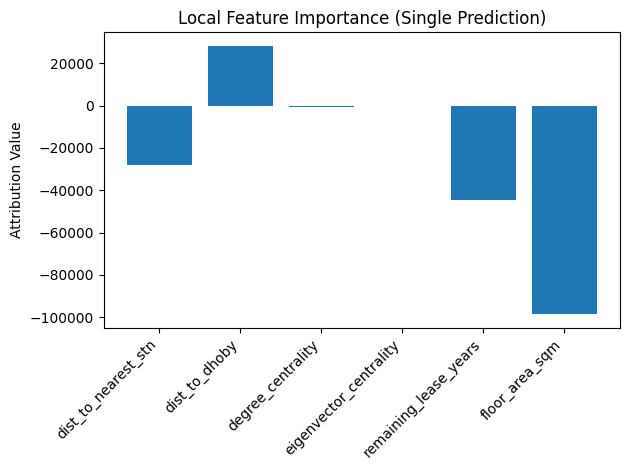


Top 5 most influential features (global explanation):
1. remaining_lease_years: 46797.308594
2. floor_area_sqm: 36447.140625
3. dist_to_dhoby: 33695.898438
4. dist_to_nearest_stn: 22332.457031
5. degree_centrality: 2536.250244


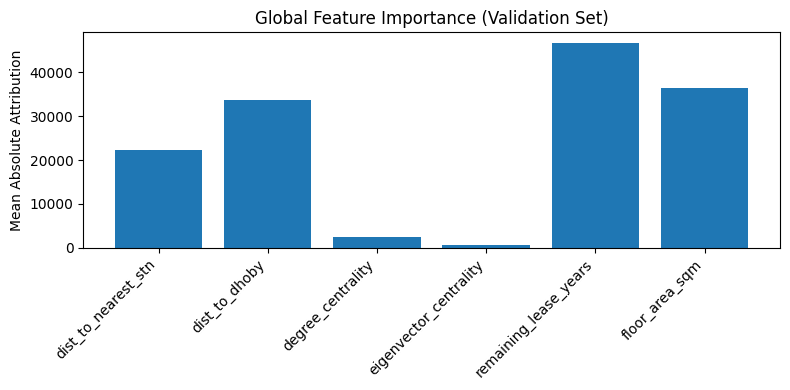

In [19]:
!pip install captum

from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# Define a forward wrapper for IG
def forward_func(x_cont, x_cat):
    lightning_model.eval()
    preds = lightning_model(x_cat, x_cont)
    return preds

# Create the Integrated Gradients object
ig = IntegratedGradients(forward_func)

# Choose one batch from test or validation set for local explanation
batch = next(iter(test_loader)) 
x_cat, x_cont, y_true = batch["x_cat"], batch["x_cont"], batch["y"]

# Baseline for continuous features (zeros)
baseline = torch.zeros_like(x_cont)
x_cont = x_cont.clone().detach().requires_grad_(True)

# Compute local attributions (per sample)
attributions_local = ig.attribute(
    inputs=x_cont,
    baselines=baseline,
    additional_forward_args=(x_cat,),
    n_steps=50
)
attributions_local = attributions_local.detach().numpy()

# Pick one example and show top 3 influential features
sample_idx = 0
sample_attr = attributions_local[sample_idx]
feature_importance = dict(zip(continuous_cols, sample_attr))
sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top 3 most influential features (local explanation):")
for i, (feat, val) in enumerate(sorted_features[:3], start=1):
    print(f"{i}. {feat}: {val:.4f}")

# Plot signed attributions for this example
plt.bar(range(len(continuous_cols)), sample_attr)
plt.xticks(range(len(continuous_cols)), continuous_cols, rotation=45, ha="right")
plt.title("Local Feature Importance (Single Prediction)")
plt.ylabel("Attribution Value")
plt.tight_layout()
plt.show()


# Global explanation across validation set
global_attributions = torch.zeros(len(continuous_cols))

# Loop through validation data and accumulate mean absolute attributions
for batch in val_loader:
    x_cat, x_cont, y_true = batch["x_cat"], batch["x_cont"], batch["y"]
    baseline = torch.zeros_like(x_cont)
    x_cont = x_cont.clone().detach().requires_grad_(True)

    attributions = ig.attribute(
        inputs=x_cont,
        baselines=baseline,
        additional_forward_args=(x_cat,),
        n_steps=20
    )
    global_attributions += attributions.abs().sum(dim=0)

# Normalize by number of samples
global_attributions = global_attributions / len(val_loader.dataset)
global_attr_np = global_attributions.detach().numpy()

# Rank by importance
global_importance = dict(zip(continuous_cols, global_attr_np))
sorted_global = sorted(global_importance.items(), key=lambda x: x[1], reverse=True)

print("\nTop 5 most influential features (global explanation):")
for i, (feat, val) in enumerate(sorted_global[:5], start=1):
    print(f"{i}. {feat}: {val:.6f}")

# Plot global feature importance
plt.figure(figsize=(8, 4))
plt.bar(range(len(continuous_cols)), global_attr_np)
plt.xticks(range(len(continuous_cols)), continuous_cols, rotation=45, ha="right")
plt.title("Global Feature Importance (Validation Set)")
plt.ylabel("Mean Absolute Attribution")
plt.tight_layout()
plt.show()


### The Integrated Gradients (IG) analysis revealed that floor_area_sqm, dist_to_nearest_stn, and remaining_lease_years were among the most influential features affecting HDB resale price predictions. These results align strongly with domain intuition as larger floor area naturally increases a flat’s market value since buyers tend to pay more for spacious units, shorter distance to MRT stations enhances accessibility and convenience, and longer remaining lease years signify greater property value compared to older flats nearing lease expiry.